### Quality-Diversity (QD) in Webcrawl
Given an `entity` to search, `GPT` first suggests query words for searching Wikipedia. Then, we crawl and summarize (with `GPT`) paragraphs of queried Wikipedia pages. 
We compute the pairwise distances between the summarized sentences using `BERT Score`. 
Finally, we evaluate the distance measures by examining the semantically closest sentences as well as subsampling using `Determinantal Point Processes`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from gpt_helper import set_openai_api_key_from_txt,GPTchatClass,printmd
from wiki_helper import wiki_search
from util import printmd,extract_quoted_words
from bert_score import score
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Ready.")

Ready.


### Set GPT Agent

In [2]:
set_openai_api_key_from_txt(key_path='../key/rilab_key.txt')
GPT = GPTchatClass(
    gpt_model='gpt-3.5-turbo',
    role_msg='Your are a helpful assistant summarizing infromation and answering user queries.')

OpenAI API Key Ready from [../key/rilab_key.txt].
Chat agent using [gpt-3.5-turbo] initialized with the follow role:[Your are a helpful assistant summarizing infromation and answering user queries.]


### Do some wiki crawl

In [3]:
entity = "Isaac Newton"
print ("entity:[%s]"%(entity))

entity:[Isaac Newton]


In [4]:
# Find three query words for the given entity using GPT
user_msg = \
    """
    Suppose you will use Wikipedia for retrieving information. 
    Could you recommend three query words wrapped with quotation marks for getting more information about """ \
    + '"' + entity + '"?' + \
    """ For example, if you are given "stubborn person", you may want to return """ \
    + """ "Characteristic of a stubborn person", "Definition of Stubborn", "Signs of Being Stubborn". """
response_content = GPT.chat(
    user_msg=user_msg,PRINT_USER_MSG=True,PRINT_GPT_OUTPUT=True,
    RESET_CHAT=True,RETURN_RESPONSE=True)
wiki_queries = extract_quoted_words(response_content)
if len(wiki_queries) > 3: wiki_queries = wiki_queries[-3:]
print ("Three query words are\n%s"%(wiki_queries))

[USER_MSG]



    Suppose you will use Wikipedia for retrieving information. 
    Could you recommend three query words wrapped with quotation marks for getting more information about "Isaac Newton"? For example, if you are given "stubborn person", you may want to return  "Characteristic of a stubborn person", "Definition of Stubborn", "Signs of Being Stubborn". 

[GPT_OUTPUT]


Certainly! Here are three query words wrapped with quotation marks that you can use to find more information about "Isaac Newton" on Wikipedia:

1. "Isaac Newton biography" - This query can help you find a detailed biography of Isaac Newton, including his early life, contributions to science, and notable achievements.

2. "Isaac Newton laws of motion" - This query can provide information on Newton's laws of motion, which are foundational principles in physics. It can help you understand the concepts behind these laws and their significance.

3. "Isaac Newton scientific discoveries" - This query can lead you to articles and information about the various scientific discoveries made by Isaac Newton, such as his work on optics, mathematics, and the laws of gravity.

By using these query words, you should be able to find in-depth information and explore different aspects of Isaac Newton's life and contributions.

Three query words are
['Isaac Newton biography', 'Isaac Newton laws of motion', 'Isaac Newton scientific discoveries']


In [5]:
# Wiki crawl on query words from GPT
paragraphs_return = []
for wiki_query in wiki_queries:
    paragraphs_return += wiki_search(
        entity=wiki_query,min_char_len=100,first_k=3,top_m_excluding_first_k=5,
        VERBOSE=True)
print ("Now we have [%d] paragraphs."%(len(paragraphs_return)))
# Get the unique paragraphs
paragraphs_unique = list(set(paragraphs_return))
print ("Number of paragraphs [%d] => unique ones [%d]"%
       (len(paragraphs_return),len(paragraphs_unique)))

entity:[Isaac Newton biography] mismatched. use [Early life of Isaac Newton] instead.
 We have total [242] paragraphs.
 After filtering, we have [57] and [8] paragraphs returned (k:[3] and m:[5])
entity:[Isaac Newton laws of motion] mismatched. use [Newton's laws of motion] instead.
 We have total [1662] paragraphs.
 After filtering, we have [133] and [8] paragraphs returned (k:[3] and m:[5])
entity:[Isaac Newton scientific discoveries] mismatched. use [Leibniz–Newton calculus controversy] instead.
 We have total [239] paragraphs.
 After filtering, we have [44] and [8] paragraphs returned (k:[3] and m:[5])
Now we have [24] paragraphs.
Number of paragraphs [24] => unique ones [24]


In [6]:
# Now summarize each paragraph to a single sentence
summarized_sentences = []
for p_idx,p in enumerate(paragraphs_unique):
    user_msg = "Could you summarize the following paragraph into one setence? \n "+p
    response_content = GPT.chat(
        user_msg=user_msg,PRINT_USER_MSG=False,PRINT_GPT_OUTPUT=False,
        RESET_CHAT=True,RETURN_RESPONSE=True)
    # Append summarized sentences
    summarized_sentences.append(response_content)
    # Print summarized sentence with a markdown format
    print ("[%d/%d]-th Paragraph"%(p_idx,len(paragraphs_unique)))
    printmd(p)
    print ("=>")
    printmd(response_content)

[0/24]-th Paragraph


Johannes Kepler suggested that gravitational attractions were reciprocal — that, for example, the Moon pulls on the Earth while the Earth pulls on the Moon — but he did not argue that such pairs are equal and opposite.[104] In his Principles of Philosophy (1644), Descartes introduced the idea that during a collision between bodies, a "quantity of motion" remains unchanged. Descartes defined this quantity somewhat imprecisely by adding up the products of the speed and "size" of each body, where "size" for him incorporated both volume and surface area.[105] Moreover, Descartes thought of the universe as a plenum, that is, filled with matter, so all motion required a body to displace a medium as it moved. During the 1650s, Huygens studied collisions between hard spheres and deduced a principle that is now identified as the conservation of momentum.[106][107] Christopher Wren would later deduce the same rules for elastic collisions that Huygens had, and John Wallis would apply momentum conservation to study inelastic collisions. Newton cited the work of Huygens, Wren, and Wallis to support the validity of his third law.[108]

=>


Johannes Kepler suggested that gravitational attractions are reciprocal, Descartes introduced the idea of "quantity of motion" remaining unchanged during collisions, Huygens studied collisions between spheres and deduced the conservation of momentum, Christopher Wren and John Wallis established rules for elastic and inelastic collisions respectively, and Newton cited their work to support his third law.

[1/24]-th Paragraph


Next November, Newton redeemed his promise to Halley by sending him, by the hand of Mr. Paget, a fellow of Trinity College and mathematical master of Christ's Hospital, a copy of his demonstration; and very soon afterward Halley again visited Cambridge to confer with Newton about the problem. On his return to London on 10 December 1684, he informed the Royal Society "that he had lately seen Mr. Newton at Cambridge, who had shown him a curious treatise De Motu",[citation needed] which at Halley's desire he promised to send to the Society to be entered upon their register. "Mr. Halley was desired to put Mr. Newton in mind of his promise for the securing this invention to himself, till he could be at leisure to publish it",[citation needed] and Paget was desired to join with Halley in urging Newton to do so. By the middle of February Newton had sent his paper to Aston, one of the secretaries of the Society, and in a letter to Aston dated 23 February 1685, Newton thanked him for "having entered on the register his notions about motion". This treatise De Motu was the starting point of the Principia,[according to whom?] and was meant[according to whom?] to be a short account of what that work was intended to embrace. It occupies twenty-four octavo pages, and consists of four theorems and seven problems, some of which are identical with some of the most important propositions of the second and third sections of the first book of the  Principia.

=>


Newton fulfilled his promise to Halley by sending him a copy of his treatise De Motu, which served as the foundation for the Principia and consisted of four theorems and seven problems.

[2/24]-th Paragraph


At first, there was no reason to suspect Leibniz's good faith. In 1699, Nicolas Fatio de Duillier, a Swiss mathematician known for his work on the zodiacal light problem, publicly accused Leibniz of plagiarizing Newton,[17] although he privately had accused Leibniz of plagiarism twice in letters to Christiaan Huygens in 1692.[18] It was not until the 1704 publication of an anonymous review of Newton's tract on quadrature, a review implying that Newton had borrowed the idea of the fluxional calculus from Leibniz, that any responsible mathematician doubted that Leibniz had invented the calculus independently of Newton. With respect to the review of Newton's quadrature work, all admit that there was no justification or authority for the statements made therein, which were rightly attributed to Leibniz. But the subsequent discussion led to a critical examination of the whole question, and doubts emerged. Had Leibniz derived the fundamental idea of the calculus from Newton? The case against Leibniz, as it appeared to Newton's friends, was summed up in the Commercium Epistolicum of 1712, which referenced all allegations. This document was thoroughly machined by Newton.

=>


Initially, Leibniz's good faith was unquestioned, but accusations of plagiarism from Swiss mathematician Nicolas Fatio de Duillier in 1699 and an anonymous review in 1704 raised doubts about whether Leibniz had independently invented calculus before Newton, leading to a critical examination and a case against Leibniz summarized in the Commercium Epistolicum of 1712.

[3/24]-th Paragraph


In March 1673 Newton took a prominent part in a dispute in the university. The public oratorship fell vacant, and a contest arose between the heads of the colleges and the members of the Senate as to the mode of electing to the office. The heads claimed the right of nominating two persons, one of whom was to be elected by the senate. The senate insisted that the proper mode was by an open election. George Villiers, 2nd Duke of Buckingham, who was the chancellor of the university, endeavoured to effect a compromise which, he says, "I hope may for the present satisfy both sides. I propose that the heads may for this time nominate and the body comply, yet interposing (if they think fit) a protestation concerning their plea that this election may not hereafter pass for a decisive precedent in prejudice of their claim",[citation needed] and, "whereas I understand that the whole university has chiefly consideration for Dr Henry Paman of St John's College and Mr. Craven of Trinity College, I do recommend them both to be nominated."[citation needed] The heads, however, nominated Drs Paman and Ralph Sanderson (of St John's); the next day 121 members of the senate recorded their votes for Craven and ninety-eight for Paman. On the morning of the election, a protest in which Newton's name appeared was read and entered in the Regent House. But the vice-chancellor admitted Paman the same morning, and so ended the first contest of a non-scientific character in which Newton took part.[citation needed]

=>


Newton took part in a dispute over the election process for the public oratorship at the university, with the heads of the colleges wanting to nominate candidates and the senate wanting an open election, but a compromise was reached and Dr Henry Paman was elected.

[4/24]-th Paragraph


In the 17th century, as at the present time, the question of scientific priority was of great importance to scientists. However, during this period, scientific journals had just begun to appear, and the generally accepted mechanism for fixing priority by publishing information about the discovery had not yet been formed. Among the methods used by scientists were anagrams, sealed envelopes placed in a safe place, correspondence with other scientists, or a private message. A letter to the founder of the French Academy of Sciences, Marin Mersenne for a French scientist, or to the secretary of the Royal Society of London, Henry Oldenburg for English, had practically the status of a published article. The discoverer could 'time-stamp' the moment of his discovery, and prove that he knew of it at the point the letter was sealed, and had not copied it from anything subsequently published. Nevertheless, where an idea was subsequently published in conjunction with its use in a particularly valuable context, this might take priority over an earlier discoverer's work, which had no obvious application. Further, a mathematician's claim could be undermined by counter-claims that he had not truly invented an idea, but merely improved on someone else's idea, an improvement that required little skill, and was based on facts that were already known.[5]

=>


During the 17th century, scientists faced challenges in establishing scientific priority without the standardized practices of publishing, resorting to methods like anagrams and sealed envelopes, while letters to prominent figures held the status of published articles, although the value of an idea in practical application could surpass an earlier discovery, and counter-claims of little skill or improvement on existing knowledge could undermine a mathematician's claim.

[5/24]-th Paragraph


Isaac Newton was born on Christmas Day, 25 December 1642 Old Style (which was 4 January 1643 on the Gregorian calendar, which is now used)[2] at Woolsthorpe Manor in Woolsthorpe-by-Colsterworth, a hamlet in the county of Lincolnshire. (At the time of Newton's birth, England had not adopted the Gregorian calendar and therefore his date of birth was recorded as 25 December, according to the Julian calendar.)

=>


Isaac Newton was born on December 25, 1642 (according to the Julian calendar) in Woolsthorpe Manor, Lincolnshire, England.

[6/24]-th Paragraph


Newton's laws are often stated in terms of point or particle masses, that is, bodies whose volume is negligible. This is a reasonable approximation for real bodies when the motion of internal parts can be neglected, and when the separation between bodies is much larger than the size of each. For instance, the Earth and the Sun can both be approximated as pointlike when considering the orbit of the former around the latter, but the Earth is not pointlike when considering activities on its surface.[note 1]

=>


Newton's laws apply to point masses, which are a reasonable approximation for real bodies when the motion of internal parts is negligible and the separation between bodies is much larger than their size.

[7/24]-th Paragraph


The following article is part of a biography of Sir Isaac Newton, the English mathematician and scientist, author of the Principia. It portrays the years after Newton's birth in 1642, his education, as well as his early scientific contributions, before the writing of his main work, the Principia Mathematica, in 1685.

=>


This article provides an overview of Sir Isaac Newton's early life, education, and scientific contributions leading up to the writing of his main work, the Principia Mathematica, in 1685.

[8/24]-th Paragraph


He then points out why "the object-glass of any telescope cannot collect all the rays which come from one point of an object, to make them convene at its focus in less room than in a circular space, whose diameter is the 50th part of the diameter of its aperture: which is an irregularity some hundreds of times greater, than a circularly figured lens, of so small a section as the object-glasses of long telescopes are, would cause by the unfitness of its figure, were light uniform."[citation needed] He adds: "This made me take reflections into consideration, and finding them regular so that the Angle of Reflection of all sorts of Rays was equal to their Angle of Incidence; I understood, that by their mediation optic instruments might be brought to any degree of perfection imaginable, provided a reflecting substance could be found, which would polish as finely as glass, and reflect as much light, as glass transmits, and the art of communicating to it a parabolic figure be also attained. But these seemed very great difficulties, and I have almost thought them insuperable, when I further considered, that every irregularity in a reflecting superficies makes the rays stray 5 or 6 times more out of their due course, than the like irregularities in a refracting one; so that a much greater curiosity would be here requisite, than in figuring glasses for refraction.[citation needed]

=>


The author discusses the limitations of telescope object-glasses in collecting rays and explores the potential of reflections in optic instruments, highlighting the challenges of finding a reflective substance that can polish to the same level as glass while achieving a parabolic figure.

[9/24]-th Paragraph


A series of high-profile disputes about the scientific priority of the 17th century – the era that the American science historian D. Meli called "the golden age of the mud-slinging priority disputes" – is associated with the name Leibniz. The first of them occurred at the beginning of 1673, during his first visit to London, when in the presence of the famous mathematician John Pell he presented his method of approximating series by differences. To Pell’s remark that this discovery had already been made by François Regnaud and published in 1670 in Lyon by Gabriel Mouton, Leibniz answered the next day.[6][7] In a letter to Oldenburg, he wrote that, having looked at Mouton's book, he admits Pell was right, but in his defense, he can provide his draft notes, which contain nuances not found by Renault and Mouton. Thus, the integrity of Leibniz was proved, but in this case, he was recalled later.[8][9] On the same visit to London, Leibniz was in the opposite position. February 1, 1673, at a meeting of the Royal Society of London, he demonstrated his mechanical calculator. The curator of the experiments of the Society, Robert Hooke, carefully examined the device and even removed the back cover for this. A few days later, in the absence of Leibniz, Hooke criticized the German scientist's machine, saying that he could make a simpler model. Leibniz, who learned about this, returned to Paris and categorically rejected Hooke’s claim in a letter to Oldenburg and formulated principles of correct scientific behavior: "We know that respectable and modest people prefer it when they think of something that is consistent with what someone's done other discoveries, ascribe their own improvements and additions to the discoverer, so as not to arouse suspicions of intellectual dishonesty, and the desire for true generosity should pursue them, instead of the lying thirst for dishonest profit." To illustrate the proper behavior, Leibniz gives an example of Nicolas-Claude Fabri de Peiresc and Pierre Gassendi, who performed astronomical observations similar to those made earlier by Galileo Galilei and Johannes Hevelius, respectively. Learning that they did not make their discoveries first, French scientists passed on their data to the discoverers.[10]

=>


A series of disputes during the 17th century, known as the "golden age of the mud-slinging priority disputes," involved Leibniz and include a disagreement over who discovered a method of approximating series by differences, in which Leibniz admitted he was not the first, and a criticism of his mechanical calculator by Robert Hooke, to which Leibniz responded by emphasizing the importance of giving credit to the original discoverers.

[10/24]-th Paragraph


That Leibniz saw some of Newton's manuscripts had always been likely. In 1849, C. I. Gerhardt, while going through Leibniz's manuscripts, found extracts from Newton's De Analysi per Equationes Numero Terminorum Infinitas (published in 1704 as part of the De Quadratura Curvarum but also previously circulated among mathematicians starting with Newton giving a copy to Isaac Barrow in 1669 and Barrow sending it to John Collins[16]) in Leibniz's handwriting, the existence of which had been previously unsuspected, along with notes re-expressing the content of these extracts in Leibniz's differential notation. Hence when these extracts were made becomes all-important. It is known that a copy of Newton's manuscript had been sent to Ehrenfried Walther von Tschirnhaus in May 1675, a time when he and Leibniz were collaborating; it is not impossible that these extracts were made then. It is also possible that they may have been made in 1676, when Leibniz discussed analysis by infinite series with Collins and Oldenburg. It is probable that they would have then shown him the manuscript of Newton on that subject, a copy of which one or both of them surely possessed. On the other hand, it may be supposed that Leibniz made the extracts from the printed copy in or after 1704. Shortly before his death, Leibniz admitted in a letter to Abbé Antonio Schinella Conti, that in 1676 Collins had shown him some of Newton's papers, but Leibniz also implied that they were of little or no value. Presumably he was referring to Newton's letters of 13 June and 24 October 1676, and to the letter of 10 December 1672, on the method of tangents, extracts from which accompanied the letter of 13 June.

=>


The discovery of extracts from Newton's manuscripts in Leibniz's handwriting, along with notes in Leibniz's differential notation, suggests that Leibniz may have seen these manuscripts during his collaboration with Tschirnhaus in 1675 or during discussions with Collins and Oldenburg in 1676, but it is also possible that he made the extracts from a printed copy after 1704.

[11/24]-th Paragraph


Newton's law of universal gravitation states that any body attracts any other body along the straight line connecting them. The size of the attracting force is proportional to the product of their masses, and inversely proportional to the square of the distance between them. Finding the shape of the orbits that an inverse-square force law will produce is known as the Kepler problem. The Kepler problem can be solved in multiple ways, including by demonstrating that the Laplace–Runge–Lenz vector is constant,[44] or by applying a duality transformation to a 2-dimensional harmonic oscillator.[45] However it is solved, the result is that orbits will be conic sections, that is, ellipses (including circles), parabolas, or hyperbolas. The eccentricity of the orbit, and thus the type of conic section, is determined by the energy and the angular momentum of the orbiting body. Planets do not have sufficient energy to escape the Sun, and so their orbits are ellipses, to a good approximation; because the planets pull on one another, actual orbits are not exactly conic sections.

=>


Newton's law of universal gravitation states that any two bodies will attract each other with a force that is proportional to their masses and inversely proportional to the square of the distance between them, resulting in conic section orbits such as ellipses.

[12/24]-th Paragraph


The concept of energy became a key part of Newtonian mechanics in the post-Newton period. Huygens' solution of the collision of hard spheres showed that in that case, not only is momentum conserved, but kinetic energy is as well (or, rather, a quantity that in retrospect we can identify as one-half the total kinetic energy). The question of what is conserved during all other processes, like inelastic collisions and motion slowed by friction, was not resolved until the 19th century. Debates on this topic overlapped with philosophical disputes between the metaphysical views of Newton and Leibniz, and variants of the term "force" were sometimes used to denote what we would call types of energy. For example, in 1742, Émilie du Châtelet wrote, "Dead force consists of a simple tendency to motion: such is that of a spring ready to relax; living force is that which a body has when it is in actual motion." In modern terminology, "dead force" and "living force" correspond to potential energy and kinetic energy respectively.[117] Conservation of energy was not established as a universal principle until it was understood that the energy of mechanical work can be dissipated into heat.[118][119] With the concept of energy given a solid grounding, Newton's laws could then be derived within formulations of classical mechanics that put energy first, as in the Lagrangian and Hamiltonian formulations described above.

=>


In the post-Newton period, the concept of energy became a fundamental part of Newtonian mechanics, with the understanding that momentum and kinetic energy are conserved during certain processes, but it wasn't until the 19th century that it was resolved what is conserved during other processes like inelastic collisions and motion slowed by friction, and debates on this topic were intertwined with philosophical disputes between Newton and Leibniz. Émilie du Châtelet described two types of energy, "dead force" and "living force," which correspond to potential energy and kinetic energy respectively in modern terminology. Conservation of energy became a universal principle when it was realized that mechanical work can be dissipated into heat, and with a solid grounding in the concept of energy, Newton's laws could be derived within classical mechanics formulations that prioritize energy.

[13/24]-th Paragraph


Sir Isaac Newton is known for many scientific findings. Some of these discoveries include the laws of motion, the theory of gravity, and basic calculus. Although Newton was predominantly known for his discoveries in mathematics and physics, he also put much effort and study into chemistry, biblical history, and optics. One of Newton's most famous writings was the Principia where he described some of his major findings of time, physics, mathematics, and calculus. Although his theories soon became universal, he faced much opposition to some of his early theories. Specifically, his theory of gravity faced criticism from leading scientists such as Christiaan Huygens and Leibniz. After a few years of debate, Newton's concept of gravity became universally accepted as he became the dominant figure in the European continent. [1]

=>


Sir Isaac Newton is known for his scientific findings in various fields such as physics, mathematics, chemistry, biblical history, and optics, including his laws of motion, theory of gravity, and basic calculus, which he described in his famous book, the Principia, and despite facing initial opposition, his theory of gravity eventually became universally accepted.

[14/24]-th Paragraph


The three laws of motion were first stated by Isaac Newton in his Philosophiæ Naturalis Principia Mathematica (Mathematical Principles of Natural Philosophy), originally published in 1687.[3] Newton used them to investigate and explain the motion of many physical objects and systems, which laid the foundation for classical mechanics. In the time since Newton, the conceptual content of classical physics has been reformulated in alternative ways, involving different mathematical approaches that have yielded insights which were obscured in the original, Newtonian formulation. Limitations to Newton's laws have also been discovered; new theories are necessary when objects move at very high speeds (special relativity), are very massive (general relativity), or are very small (quantum mechanics).

=>


Isaac Newton's three laws of motion, first stated in his book published in 1687, laid the foundation for classical mechanics and have been reinterpreted and expanded upon over time as new theories such as special relativity, general relativity, and quantum mechanics have emerged to address the limits of Newton's laws.

[15/24]-th Paragraph


In November 1679, Robert Hooke (after his appointment to manage the Royal Society's correspondence) began an exchange of letters with Newton[citation needed]: he wished to hear from members about their researches, or their views about the researches of others.[20] The correspondence later led to controversy. Hooke and Newton disagreed about the form of the path of a body falling from a height, taking the motion of the Earth around its axis into consideration. Newton later acknowledged that the exchanges of 1679–80 had reawakened his dormant interest in astronomy.[21] This led Newton to revert[according to whom?] to his former conjectures on the Moon. The estimate Newton had used for the radius of the Earth, which had been accepted by geographers and navigators, was based on the very rough estimate that the length of a degree of latitude of the Earth's surface measured along a meridian was 60 nautical miles.[according to whom?] At a meeting of the Royal Society on 11 January 1672, Oldenburg, the secretary, read a letter from Paris describing the procedure followed by Jean Picard in measuring a degree, and specifically stating the precise length that he calculated it to be. It is probable that Newton had become acquainted with this measurement of Picard's, and that he was therefore led to make use of it when his thoughts were redirected to the subject. This estimate of the Earth's magnitude, giving 691 miles (1112  km) to 10°, made the two results, the discrepancy between which Newton had regarded as a disproof of his conjecture, to agree so exactly that he now regarded his conjecture as fully established.

=>


In 1679, Robert Hooke and Isaac Newton had a letter exchange discussing the path of a falling body, which ultimately reignited Newton's interest in astronomy and led him to revise his conjectures on the Moon by using a more accurate measurement for the Earth's radius.

[16/24]-th Paragraph


Newton's laws of motion are three basic laws of classical mechanics that describe the relationship between the motion of an object and the forces acting on it. These laws can be paraphrased as follows:

=>


Newton's laws of motion explain how an object moves in relation to the forces acting on it.

[17/24]-th Paragraph


The subject of physics is often traced back to Aristotle; however, the history of the concepts involved is obscured by multiple factors. An exact correspondence between Aristotelian and modern concepts is not simple to establish: Aristotle did not clearly distinguish what we would call speed and force, and he used the same term for density and viscosity; he conceived of motion as always through a medium, rather than through space. In addition, some concepts often termed "Aristotelian" might better be attributed to his followers and commentators upon him.[88] These commentators found that Aristotelian physics had difficulty explaining projectile motion.[note 17] Aristotle divided motion into two types: "natural" and "violent". The "natural" motion of terrestrial solid matter was to fall downwards, whereas a "violent" motion could push a body sideways. Moreover, in Aristotelian physics, a "violent" motion requires an immediate cause; separated from the cause of its "violent" motion, a body would revert to its "natural" behavior. Yet a javelin continues moving after it leaves the hand of its thrower. Aristotle concluded that the air around the javelin must be imparted with the ability to move the javelin forward. John Philoponus, a Byzantine Greek thinker active during the sixth century, found this absurd: the same medium, air, was somehow responsible both for sustaining motion and for impeding it. If Aristotle's idea were true, Philoponus said, armies would launch weapons by blowing upon them with bellows. Philoponus argued that setting a body into motion imparted a quality, impetus, that would be contained within the body itself. As long as its impetus was sustained, the body would continue to move.[90]: 47  In the following centuries, versions of impetus theory were advanced by individuals including Nur ad-Din al-Bitruji, Avicenna, Abu'l-Barakāt al-Baghdādī, John Buridan, and Albert of Saxony. In retrospect, the idea of impetus can be seen as a forerunner of the modern concept of momentum.[note 18] (The intuition that objects move according to some kind of impetus persists in many students of introductory physics.[92])

=>


The history of physics, particularly the concepts of speed, force, density, and viscosity, can be obscured by multiple factors, including Aristotle's lack of clear distinctions and the contributions of his followers and commentators, with the idea of impetus being a precursor to the modern concept of momentum.

[18/24]-th Paragraph


During the years 1666 to 1669 Newton's studies were very diverse. He bought prisms and lenses on two or three occasions, and also chemicals and a furnace, apparently for chemical experiments[citation needed]; but he also employed part of his time on the theory of fluxions and other branches of pure mathematics. He wrote a paper, De Analysi per Aequationes Numero Terminorum Infinitas, which he put, probably in June 1669, into the hands of Isaac Barrow (then Lucasian Professor of Mathematics), at the same time permitting him to communicate its contents to their common friend John Collins (1624–1683), a mathematician of no mean order. Barrow did so on 31 July 1669, but kept the name of the author a secret, and merely told Collins that he was a friend staying at Cambridge, who had a powerful genius for such matters.[according to whom?] In a subsequent letter on 20 August Barrow expressed his pleasure at hearing the favourable opinion which Collins had formed of the paper, and added, "the name of the author is Newton, a fellow of our college, and a young man, who is only in his second year since he took the degree of Master of Arts, and who, with an unparalleled genius (examine quo est acumen), has made very great progress in this branch of mathematics".[citation needed] Shortly afterward Barrow resigned his chair and was instrumental in securing Newton's election as his successor.

=>


During 1666 to 1669, Newton engaged in diverse studies including experiments with prisms and lenses, chemical experiments, and mathematical pursuits such as the theory of fluxions, ultimately leading to the writing of a paper which he shared with Isaac Barrow and John Collins.

[19/24]-th Paragraph


Newton said he had begun working on a form of calculus (which he called "the method of fluxions and fluents") in 1666, at the age of 23, but did not publish it except as a minor annotation in the back of one of his publications decades later (a relevant Newton manuscript of October 1666 is now published among his mathematical papers[1]). Gottfried Leibniz began working on his variant of calculus in 1674, and in 1684 published his first paper employing it, "Nova Methodus pro Maximis et Minimis". L'Hôpital published a text on Leibniz's calculus in 1696 (in which he recognized that Newton's Principia of 1687 was "nearly all about this calculus"). Meanwhile, Newton, though he explained his (geometrical) form of calculus in Section I of Book I of the Principia of 1687,[2] did not explain his eventual fluxional notation for the calculus[3] in print until 1693 (in part) and 1704 (in full).

=>


Newton and Leibniz independently developed their versions of calculus in the late 17th century, with Newton beginning his work in 1666 but not publishing it until decades later, while Leibniz published his first paper on calculus in 1684, and L'Hôpital recognized that Newton's Principia of 1687 was mostly about calculus. Newton explained his method in the Principia but did not publish his notation until 1693 and 1704.

[20/24]-th Paragraph


The prevailing opinion in the 18th century was against Leibniz (in Britain, not in the German-speaking world). Today the consensus is that Leibniz and Newton independently invented and described the calculus in Europe in the 17th century.

=>


The prevailing opinion in the 18th century was against Leibniz in Britain, but today the consensus is that both Leibniz and Newton independently invented calculus in Europe in the 17th century.

[21/24]-th Paragraph


Leibniz never agreed to acknowledge Newton's priority in inventing calculus. He also tried to write his own version of the history of differential calculus, but, as in the case of the history of the rulers of Braunschweig, he did not complete the matter.[19] At the end of 1715, Leibniz accepted Johann Bernoulli's offer to organize another mathematician competition, in which different approaches had to prove their worth. This time the problem was taken from the area later called the calculus of variations – it was required to construct a tangent line to a family of curves. A letter with the wording was written on 25 November and transmitted in London to Newton through Abate Conti. The problem was formulated in not very clear terms, and only later it became clear that it was required to find a general, and not a particular, as Newton understood, solution. After the British side published their decision, Leibniz published his, more general, and, thus, formally won this competition.[20] For his part, Newton stubbornly sought to destroy his opponent. Not having achieved this with the "Report", he continued his painstaking research, spending hundreds of hours on it. His next study, entitled "Observations upon the preceding Epistle", was inspired by a letter from Leibniz to Conti in March 1716, which criticized Newton's philosophical views; no new facts were given in this document.[21] With Leibniz's death in November 1716, the controversy gradually subsided. According to A. Rupert Hall, after 1722 this question ceased to interest Newton himself.[22]

=>


Leibniz and Newton had a long-standing dispute over the invention of calculus, and Leibniz won a mathematician competition in 1715 with a more general solution, while Newton continued to try to discredit him.

[22/24]-th Paragraph


One important characteristic of Newtonian physics is that forces can act at a distance without requiring physical contact.[note 19] For example, the Sun and the Earth pull on each other gravitationally, despite being separated by millions of kilometres. This contrasts with the idea, championed by Descartes among others, that the Sun's gravity held planets in orbit by swirling them in a vortex of transparent matter, aether.[102] Newton considered aetherial explanations of force but ultimately rejected them.[100] The study of magnetism by William Gilbert and others created a precedent for thinking of immaterial forces,[100] and unable to find a quantitatively satisfactory explanation of his law of gravity in terms of an aetherial model, Newton eventually declared, "I feign no hypotheses": whether or not a model like Descartes's vortices could be found to underlie the Principia's theories of motion and gravity, the first grounds for judging them must be the successful predictions they made.[103] And indeed, since Newton's time every attempt at such a model has failed.

=>


Newtonian physics allows for forces to act at a distance without physical contact, such as the gravitational pull between the Sun and the Earth, debunking Descartes' idea of planets being held in orbit by swirling aether.

[23/24]-th Paragraph


In the history of calculus, the calculus controversy (German: Prioritätsstreit, lit. 'priority dispute') was an argument between the mathematicians Isaac Newton and Gottfried Wilhelm Leibniz over who had first invented calculus. The question was a major intellectual controversy, which began simmering in 1699 and broke out in full force in 1711. Leibniz had published his work first, but Newton's supporters accused Leibniz of plagiarizing Newton's unpublished ideas. Leibniz died in disfavor in 1716 after his patron, the Elector Georg Ludwig of Hanover, became King George I of Great Britain in 1714. The modern consensus is that the two men developed their ideas independently.

=>


The paragraph discusses the calculus controversy between Isaac Newton and Gottfried Wilhelm Leibniz, which was a dispute over who had first invented calculus, resulting in accusations of plagiarism, but the modern consensus is that both men developed their ideas independently.

In [7]:
# Compute the pairwise distance between summarized sentences using BERT Score
n_sentence = len(summarized_sentences)
D = np.zeros((n_sentence,n_sentence))
for j_idx in range(n_sentence):
    sentence_i = summarized_sentences
    sentence_j = [summarized_sentences[j_idx]]*n_sentence
    P,R,F1 = score(cands=sentence_i,
                   refs=sentence_j,
                   lang='en',
                   model_type='bert-base-uncased',
                   verbose=False)
    D[j_idx,] = 1.0-F1.numpy()
print ("Done.")

Done.


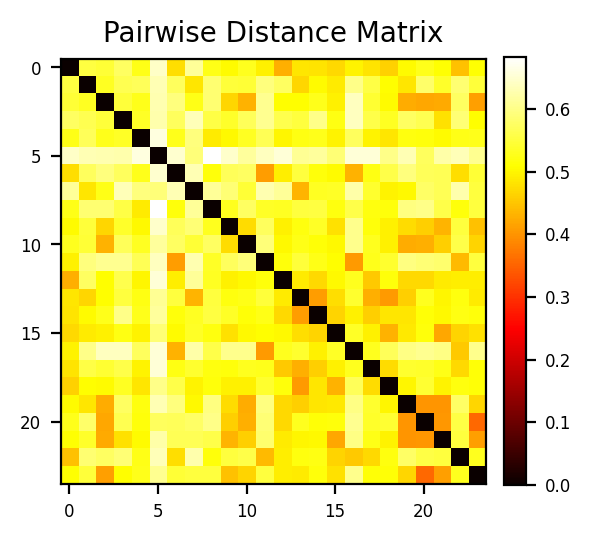

In [8]:
# Plot pairwise distance between sentences
plt.figure(figsize=(3,3))
im = plt.imshow(D,cmap='hot',interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Pairwise Distance Matrix',fontsize=10)
plt.show()

### Check the closest sentence pairs

In [9]:
k_closest_pairs = 3
D_UT = np.triu(m=D,k=1) # get upper-triangular part (+excluding diag)
D_UT[D_UT==0.0] = 100 # exclude zero distances
indices = np.argpartition(a=D_UT,kth=k_closest_pairs,axis=None)[:k_closest_pairs]
distances = D_UT.flat[indices]
sorted_indices = indices[np.argsort(distances)]
i_idxs,j_idxs = np.unravel_index(sorted_indices,D_UT.shape)
for i_idx,j_idx in zip(i_idxs,j_idxs):
    sentence_i = summarized_sentences[i_idx]
    sentence_j = summarized_sentences[j_idx]
    print ("Sentence:[%d] and Sentence:[%d] has dist:[%.4f]"%
           (i_idx,j_idx,D[i_idx,j_idx]))
    printmd (sentence_i)
    printmd (sentence_j)

Sentence:[20] and Sentence:[23] has dist:[0.3573]


The prevailing opinion in the 18th century was against Leibniz in Britain, but today the consensus is that both Leibniz and Newton independently invented calculus in Europe in the 17th century.

The paragraph discusses the calculus controversy between Isaac Newton and Gottfried Wilhelm Leibniz, which was a dispute over who had first invented calculus, resulting in accusations of plagiarism, but the modern consensus is that both men developed their ideas independently.

Sentence:[19] and Sentence:[21] has dist:[0.4006]


Newton and Leibniz independently developed their versions of calculus in the late 17th century, with Newton beginning his work in 1666 but not publishing it until decades later, while Leibniz published his first paper on calculus in 1684, and L'Hôpital recognized that Newton's Principia of 1687 was mostly about calculus. Newton explained his method in the Principia but did not publish his notation until 1693 and 1704.

Leibniz and Newton had a long-standing dispute over the invention of calculus, and Leibniz won a mathematician competition in 1715 with a more general solution, while Newton continued to try to discredit him.

Sentence:[19] and Sentence:[20] has dist:[0.4021]


Newton and Leibniz independently developed their versions of calculus in the late 17th century, with Newton beginning his work in 1666 but not publishing it until decades later, while Leibniz published his first paper on calculus in 1684, and L'Hôpital recognized that Newton's Principia of 1687 was mostly about calculus. Newton explained his method in the Principia but did not publish his notation until 1693 and 1704.

The prevailing opinion in the 18th century was against Leibniz in Britain, but today the consensus is that both Leibniz and Newton independently invented calculus in Europe in the 17th century.

### Subset sampling using `LA-DPP`

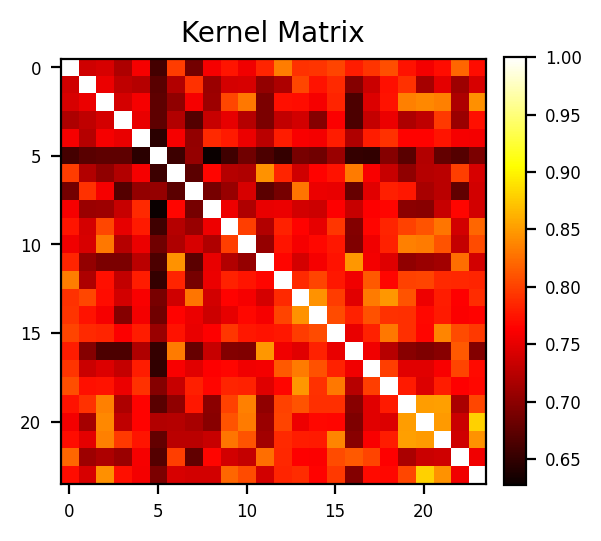

In [10]:
tau = 1.0 # temperature
K = np.exp(-D*D/tau)
# Plot the kernel matrix
plt.figure(figsize=(3,3))
im = plt.imshow(K,cmap='hot',interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Kernel Matrix',fontsize=10)
plt.show()

In [11]:
def get_dpp_subset_from_K(K,n_sel,init_idx=None):
    n_total     = K.shape[0]
    remain_idxs = np.arange(n_total)
    sub_idx     = np.zeros((n_sel))
    sum_K_vec   = np.zeros(n_total)
    for i_idx in range(n_sel):
        if i_idx == 0:
            if init_idx is None:
                sel_idx = np.random.randint(n_total) # random first
            else:
                sel_idx = init_idx
        else:
            curr_K_vec = K[(int)(sub_idx[i_idx-1]),:] 
            sum_K_vec  = sum_K_vec + curr_K_vec
            k_vals     = sum_K_vec[remain_idxs]
            min_idx    = np.argmin(k_vals)
            sel_idx    = remain_idxs[min_idx] 
        sub_idx[i_idx] = (int)(sel_idx)
        remain_idxs = np.delete(remain_idxs,np.argwhere(remain_idxs==sel_idx))
    sub_idx = sub_idx.astype(np.int32) # make it int
    return sub_idx
print ("Ready.")

Ready.


In [15]:
# Among all sentences, find the one that is closest to `entity`
n_sentence = len(summarized_sentences)
refs = ["Information about " + entity]*n_sentence
P,R,F1 = score(cands=summarized_sentences,
               refs=refs,
               lang='en',
               model_type='bert-base-uncased',
               verbose=False)
dists2entity = 1-F1.numpy()
# Print
top_k = 10
k_indices = np.argpartition(dists2entity,top_k)[:top_k]
sorted_k_indices = k_indices[np.argsort(dists2entity[k_indices])]
for i_idx,sentence_idx in enumerate(sorted_k_indices):
    dist = dists2entity[sentence_idx]
    sentence = summarized_sentences[sentence_idx]
    VERBOSE = False
    if VERBOSE:
        print ("[%d/%d] dist:[%.3f]"%(i_idx,top_k,dist))
        printmd(sentence)
print ("Done.")        

Done.


In [16]:
n_sel = 10
idxs_dpp = get_dpp_subset_from_K(K,n_sel=n_sel,init_idx=sorted_k_indices[0])
for i_idx,sentence_idx in enumerate(idxs_dpp):
    sentence = summarized_sentences[sentence_idx]
    printmd(sentence)

In 1679, Robert Hooke and Isaac Newton had a letter exchange discussing the path of a falling body, which ultimately reignited Newton's interest in astronomy and led him to revise his conjectures on the Moon by using a more accurate measurement for the Earth's radius.

Isaac Newton was born on December 25, 1642 (according to the Julian calendar) in Woolsthorpe Manor, Lincolnshire, England.

The author discusses the limitations of telescope object-glasses in collecting rays and explores the potential of reflections in optic instruments, highlighting the challenges of finding a reflective substance that can polish to the same level as glass while achieving a parabolic figure.

Newton's laws of motion explain how an object moves in relation to the forces acting on it.

This article provides an overview of Sir Isaac Newton's early life, education, and scientific contributions leading up to the writing of his main work, the Principia Mathematica, in 1685.

Newton took part in a dispute over the election process for the public oratorship at the university, with the heads of the colleges wanting to nominate candidates and the senate wanting an open election, but a compromise was reached and Dr Henry Paman was elected.

The prevailing opinion in the 18th century was against Leibniz in Britain, but today the consensus is that both Leibniz and Newton independently invented calculus in Europe in the 17th century.

Newton fulfilled his promise to Halley by sending him a copy of his treatise De Motu, which served as the foundation for the Principia and consisted of four theorems and seven problems.

Newton's law of universal gravitation states that any two bodies will attract each other with a force that is proportional to their masses and inversely proportional to the square of the distance between them, resulting in conic section orbits such as ellipses.

During the 17th century, scientists faced challenges in establishing scientific priority without the standardized practices of publishing, resorting to methods like anagrams and sealed envelopes, while letters to prominent figures held the status of published articles, although the value of an idea in practical application could surpass an earlier discovery, and counter-claims of little skill or improvement on existing knowledge could undermine a mathematician's claim.